# ASSIGNMENT 2

In [ ]:
#!pip install torchsummary
#pip install interpret
#!pip install imblearn

In [ ]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from interpret.glassbox import ExplainableBoostingClassifier

## Task 1

In [ ]:
identity  = pd.read_csv('data_identity.csv')
transaction = pd.read_csv('data_transaction.csv')

In [ ]:
joined_table = pd.merge(identity,transaction, on = 'TransactionID')
joined_table = joined_table.drop([col for col in joined_table if joined_table[col].dtype  == 'object'], axis = 1)
joined_table = joined_table.astype('float32')

In [ ]:
transaction = None
identity = None

In [ ]:
k = 1
empty_columns = []
for elem in joined_table.columns:
    if joined_table[elem].isnull().values.all():
        empty_columns.append(elem)
joined_table = joined_table.drop(empty_columns, axis = 1)

X = joined_table.fillna(0.0)
X = X.reset_index().drop(['index'] , axis = 1)

indicator = []
for ind in range(joined_table.shape[0]):
    indicator.append([int(not elem) for elem in joined_table.iloc[ind].isna()])
indicator = np.array(indicator)
indicator = pd.DataFrame(indicator, columns = joined_table.columns, dtype = 'float32')

In [ ]:
joined_table.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987004.0,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2987008.0,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987010.0,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987011.0,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987016.0,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144228,3577521.0,-15.0,145955.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144229,3577526.0,-5.0,172059.0,NaN,NaN,1.0,-5.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
144230,3577529.0,-20.0,632381.0,NaN,NaN,-1.0,-36.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144231,3577531.0,-5.0,55528.0,0.0,0.0,0.0,-7.0,NaN,NaN,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Mean strategy for imputing

In [ ]:
imputer = SimpleImputer(strategy='mean')
imputer.fit_transform(joined_table).shape
mask = pd.DataFrame(imputer.fit_transform(joined_table), columns=joined_table.columns)

In [ ]:
scaler = MinMaxScaler()
mask = scaler.fit_transform(mask)

AE_input = np.array([(m,i) for m, i in zip(np.array(mask), np.array(indicator))])

In [ ]:
print(mask.shape, indicator.shape, joined_table.shape)

(144233, 390) (144233, 390) (144233, 390)


## APPROACHES FOR MEAN AND MODE

In [ ]:
scaler = MinMaxScaler()

mean_imputer = SimpleImputer(strategy='mean')
mean_approach = pd.DataFrame(mean_imputer.fit_transform(joined_table), columns=joined_table.columns)
mean_approach = pd.DataFrame(scaler.fit_transform(mean_approach), columns=joined_table.columns)
mean_approach.to_csv(r'mean_approach', index=False)


mode_imputer = SimpleImputer(strategy='most_frequent')
mode_approach = pd.DataFrame(mode_imputer.fit_transform(joined_table), columns=joined_table.columns)
mode_approach = pd.DataFrame(scaler.fit_transform(mode_approach), columns=joined_table.columns)
mode_approach.to_csv(r'mode_approach', index=False)

### 1.2 Auto Encoder

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

#### 1.2.1 Undercomplete Autoencoder

In [ ]:
class autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
      super(autoencoder, self).__init__()
      self.encoder = nn.Sequential(
          nn.Linear(input_size, input_size//2),
          nn.LeakyReLU(),
          nn.Linear(input_size//2, input_size//3),
          nn.LeakyReLU(),
          nn.Linear(input_size//3, input_size//4),
          nn.LeakyReLU(),
          nn.Linear(input_size//4, latent_dim),
          nn.LeakyReLU()
      )
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, input_size//4),
          nn.ReLU(),
          nn.Linear(input_size//4, input_size//3),
          nn.ReLU(),
          nn.Linear(input_size//3, input_size//2),
          nn.ReLU(),
          nn.Linear(input_size//2, input_size),
          nn.Tanh()
      )
      self.encoder.apply(self.__init_weights)
      self.decoder.apply(self.__init_weights)
        
    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x
        
    def encode(self,input):
      return self.encoder(input)
    
    def __init_weights(self,m):
      if type(m) == nn.Linear:
          torch.nn.init.xavier_uniform_(m.weight)
          m.bias.data.fill_(0.01)

In [ ]:
AE = autoencoder(AE_input.shape[-1],50).to(device)
print(AE)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=390, out_features=195, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=195, out_features=130, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=130, out_features=97, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=97, out_features=50, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=97, bias=True)
    (1): ReLU()
    (2): Linear(in_features=97, out_features=130, bias=True)
    (3): ReLU()
    (4): Linear(in_features=130, out_features=195, bias=True)
    (5): ReLU()
    (6): Linear(in_features=195, out_features=390, bias=True)
    (7): Tanh()
  )
)


In [ ]:
learning_rate = 0.002
num_epochs = 25
criterion = nn.L1Loss(reduction='sum')
optimizer = torch.optim.Adam(AE.parameters(),lr=learning_rate)
data_loader = DataLoader(AE_input, batch_size=64,shuffle=True)

X_reconstuct = []
Original_X = []
I_X = []
for epoch in range(num_epochs):
  epoch_loss = list()
  for X_batch in data_loader:
    X, indic = X_batch[:, 0, :].to(device), X_batch[:, 1, :].to(device)
    optimizer.zero_grad()
    
    X_hat = AE(X)
    loss = criterion(torch.mul(indic, X), torch.mul(indic, X_hat))

    loss.backward()
    optimizer.step()

    epoch_loss.append(loss.item())
    
  with torch.no_grad():
    X_reconstuct.append(AE(X))
    Original_X.append(X)
    I_X.append(1 - indic)
    
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, np.mean(epoch_loss)))

epoch [1/25], loss:339.5121
epoch [2/25], loss:243.6956
epoch [3/25], loss:223.0826
epoch [4/25], loss:209.5512
epoch [5/25], loss:196.1432
epoch [6/25], loss:186.8426
epoch [7/25], loss:171.3998
epoch [8/25], loss:155.1210
epoch [9/25], loss:148.6340
epoch [10/25], loss:142.1903
epoch [11/25], loss:137.6241
epoch [12/25], loss:134.4864
epoch [13/25], loss:133.4642
epoch [14/25], loss:131.6101
epoch [15/25], loss:126.8570
epoch [16/25], loss:123.4985
epoch [17/25], loss:121.8739
epoch [18/25], loss:120.9497
epoch [19/25], loss:123.0770
epoch [20/25], loss:119.4522
epoch [21/25], loss:120.6210
epoch [22/25], loss:119.0375
epoch [23/25], loss:121.7632
epoch [24/25], loss:119.3797
epoch [25/25], loss:117.6711


In [ ]:
data_loader = DataLoader(AE_input, batch_size=64,shuffle=False)

X_undercomplete = []
for X_batch in data_loader:
  for X in X_batch[:, 0, :]:
    with torch.no_grad():
        AE.eval()
        X_undercomplete.append(AE(X.float()).numpy())
  
np.array(X_undercomplete).shape

(144233, 390)

In [ ]:
pd_undercomplete = pd.DataFrame(X_undercomplete, columns=joined_table.columns)
pd_undercomplete.to_csv(r'pd_undercomplete', index=False)

# Regularized autoencoder

In [ ]:
print(AE)

model_children = list(AE.children())

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=390, out_features=195, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=195, out_features=130, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=130, out_features=97, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=97, out_features=50, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
  )
  (decoder): Sequential(
    (0): Linear(in_features=50, out_features=97, bias=True)
    (1): ReLU()
    (2): Linear(in_features=97, out_features=130, bias=True)
    (3): ReLU()
    (4): Linear(in_features=130, out_features=195, bias=True)
    (5): ReLU()
    (6): Linear(in_features=195, out_features=390, bias=True)
    (7): Tanh()
  )
)


In [ ]:
# DEFINING REGULARIZATION LOSS

In [ ]:
def sparse_loss(autoencoder, data):
    loss = 0
    values = data
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        loss += torch.mean(torch.abs(values))
    return loss

In [ ]:
learning_rate = 0.002
num_epochs = 25
criterion = nn.L1Loss(reduction='sum')
optimizer = torch.optim.Adam(AE.parameters(),lr=learning_rate)
data_loader = DataLoader(AE_input, batch_size=64,shuffle=True)
reg_param = 1.0


X_reconstuct = []
Original_X = []
I_X = []
for epoch in range(num_epochs):
  epoch_loss = list()
  for X_batch in data_loader:
    X, indic = X_batch[:, 0, :].to(device), X_batch[:, 1, :].to(device)

    optimizer.zero_grad()
    X_hat = AE(X)
    loss = criterion(torch.mul(indic, X), torch.mul(indic, X_hat))
    l1_loss = sparse_loss(AE, X)
    loss = loss + reg_param * l1_loss

    loss.backward()
    optimizer.step()

    epoch_loss.append(loss.item())
    
  with torch.no_grad():
    X_reconstuct.append(AE(X))
    Original_X.append(X)
    I_X.append(1 - indic)
  # log
  print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, np.mean(epoch_loss)))

epoch [1/25], loss:118.7757
epoch [2/25], loss:117.4605
epoch [3/25], loss:118.1848
epoch [4/25], loss:115.2087
epoch [5/25], loss:114.9248
epoch [6/25], loss:116.0172
epoch [7/25], loss:112.6678
epoch [8/25], loss:112.6040
epoch [9/25], loss:112.1812
epoch [10/25], loss:111.7484
epoch [11/25], loss:120.8103
epoch [12/25], loss:117.7912
epoch [13/25], loss:114.2734
epoch [14/25], loss:114.5020
epoch [15/25], loss:112.7838
epoch [16/25], loss:111.3956
epoch [17/25], loss:111.0736
epoch [18/25], loss:110.8399
epoch [19/25], loss:110.9074
epoch [20/25], loss:110.6177
epoch [21/25], loss:111.0417
epoch [22/25], loss:110.3374
epoch [23/25], loss:113.8784
epoch [24/25], loss:111.2613
epoch [25/25], loss:111.9568


In [ ]:
data_loader = DataLoader(AE_input, batch_size=64,shuffle=False)

X_regularized = []
for X_batch in data_loader:
  for X in X_batch[:, 0, :]:
    with torch.no_grad():
        AE.eval()
        X_regularized.append(AE(X.float()).numpy())
  
np.array(X_regularized).shape

(144233, 390)

In [ ]:
pd_regularized = pd.DataFrame(X_regularized, columns=joined_table.columns)
pd_regularized.to_csv(r'pd_regularized', index=False)

# VARIATIONAL AUTOENCODER

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size=390, h_dim=400, z_dim=50):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(input_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, input_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return F.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x[0]*x[1])
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
batchSize = 64 
learning_rate = 0.05 
num_epochs = 25 
X_reconstuct = []
Original_X = []
I_X = []
epoch_loss = []

for epoch in range(num_epochs):
    for  X_batch in data_loader:
        x, indic = X_batch[:, 0, :].to(device), X_batch[:, 1, :].to(device)
        x_reconst, mu, log_var = model(x.float())
        reconst_loss = criterion(indic * x, indic * x_reconst)
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        epoch_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, np.mean(epoch_loss)))

C:\Users\Mauricio\anaconda3\lib\site-packages\torch\nn\functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch [1/25], loss:461.4106
epoch [2/25], loss:416.9871
epoch [3/25], loss:396.2362
epoch [4/25], loss:383.5941
epoch [5/25], loss:374.7254
epoch [6/25], loss:368.2826
epoch [7/25], loss:363.2577
epoch [8/25], loss:359.3211
epoch [9/25], loss:356.1127
epoch [10/25], loss:353.4022
epoch [11/25], loss:350.9548
epoch [12/25], loss:348.9056
epoch [13/25], loss:347.0969
epoch [14/25], loss:345.5533
epoch [15/25], loss:344.0623
epoch [16/25], loss:343.0020
epoch [17/25], loss:342.0407
epoch [18/25], loss:341.2294
epoch [19/25], loss:340.5282
epoch [20/25], loss:339.8868
epoch [21/25], loss:339.2862
epoch [22/25], loss:338.7240
epoch [23/25], loss:338.1885
epoch [24/25], loss:337.6669
epoch [25/25], loss:337.1725


In [ ]:
data_loader = DataLoader(AE_input, batch_size=64,shuffle=False)

X_variational = []
for X_batch in data_loader:
  for X in X_batch[:, 0, :]:
    with torch.no_grad():
        AE.eval()
        X_variational.append(AE(X.float()).numpy())
  
np.array(X_variational).shape

(144233, 390)

In [ ]:
pd_variational = pd.DataFrame(X_variational, columns=joined_table.columns)
pd_variational.to_csv(r'pd_variational', index=False)

# Task 2
### 2.1 

In [2]:
pip install interpret

     |████████████████████████████████| 6.6 MB 13.0 MB/s 
     |████████████████████████████████| 280 kB 6.2 MB/s 
     |████████████████████████████████| 564 kB 67.7 MB/s 
     |████████████████████████████████| 275 kB 64.3 MB/s 
     |████████████████████████████████| 131 kB 62.1 MB/s 
     |████████████████████████████████| 793 kB 62.6 MB/s 
     |████████████████████████████████| 756 kB 56.2 MB/s 
     |████████████████████████████████| 9.8 MB 56.5 MB/s 
     |████████████████████████████████| 3.6 MB 56.1 MB/s 
     |████████████████████████████████| 5.8 MB 54.9 MB/s 
     |████████████████████████████████| 251 kB 71.6 MB/s 
     |████████████████████████████████| 130 kB 68.2 MB/s 
     |████████████████████████████████| 428 kB 43.5 MB/s 
     |████████████████████████████████| 381 kB 64.4 MB/s 
     |████████████████████████████████| 81 kB 12.6 MB/s 
     |████████████████████████████████| 357 kB 72.7 MB/s 
     |████████████████████████████████| 65 kB 5.1 MB/s 
  Created wheel fo

In [3]:
import numpy as np
import math
import random
import os
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, utils
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import preprocessing
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from interpret.glassbox import ExplainableBoostingClassifier

In [ ]:
train_path = 'UNSW_NB15_training-set.csv'
trainset  = pd.read_csv(train_path)

In [ ]:
trainset.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
columnas = list()

for col in list(trainset.columns):
    valuesinside = len(list(trainset[col].unique()))/len(trainset[col])
    if valuesinside >= 0.01:
       columnas.append(col)

columnas = columnas + ["attack_cat"] + ["label"]
trainset = trainset[columnas]
cattrain = trainset["attack_cat"]
trainset.drop("attack_cat", axis=1, inplace=True)
trainset.head()

,id,dur,sbytes,dbytes,rate,sload,dload,sinpkt,dinpkt,sjit,djit,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,response_body_len,label
0,1,0.000011,496,0,90909.0902,180363632.0,0.0,0.011,0.0,0.0,0.0,0,0,0.0,0.0,0.0,248,0,0,0
1,2,0.000008,1762,0,125000.0003,881000000.0,0.0,0.008,0.0,0.0,0.0,0,0,0.0,0.0,0.0,881,0,0,0
2,3,0.000005,1068,0,200000.0051,854400000.0,0.0,0.005,0.0,0.0,0.0,0,0,0.0,0.0,0.0,534,0,0,0
3,4,0.000006,900,0,166666.6608,600000000.0,0.0,0.006,0.0,0.0,0.0,0,0,0.0,0.0,0.0,450,0,0,0
4,5,0.000010,2126,0,100000.0025,850400000.0,0.0,0.010,0.0,0.0,0.0,0,0,0.0,0.0,0.0,1063,0,0,0


In [ ]:
test_path = 'UNSW_NB15_testing-set.csv'
testset  = pd.read_csv(test_path)
testset = testset[columnas]
cattest = testset["attack_cat"]
testset.drop("attack_cat", axis=1, inplace=True)

In [ ]:
testset.head()

,id,dur,sbytes,dbytes,rate,sload,dload,sinpkt,dinpkt,sjit,djit,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,response_body_len,label
0,1,0.121478,258,172,74.087490,14158.942380,8495.365234,24.295600,8.375000,30.177547,11.830604,621772692,2202533631,0.000000,0.000000,0.000000,43,43,0,0
1,2,0.649902,734,42014,78.473372,8395.112305,503571.312500,49.915000,15.432865,61.426934,1387.778330,1417884146,3077387971,0.000000,0.000000,0.000000,52,1106,0,0
2,3,1.623129,364,13186,14.170161,1572.271851,60929.230470,231.875571,102.737203,17179.586860,11420.926230,2116150707,2963114973,0.111897,0.061458,0.050439,46,824,0,0
3,4,1.681642,628,770,13.677108,2740.178955,3358.622070,152.876547,90.235726,259.080172,4991.784669,1107119177,1047442890,0.000000,0.000000,0.000000,52,64,0,0
4,5,0.449454,534,268,33.373826,8561.499023,3987.059814,47.750333,75.659602,2415.837634,115.807000,2436137549,1977154190,0.128381,0.071147,0.057234,53,45,0,0


In [ ]:
columnas.remove("attack_cat")

In [ ]:
scaler = MinMaxScaler()
trainset = pd.DataFrame(scaler.fit_transform(trainset[columnas]), columns=columnas)
testset = pd.DataFrame(scaler.transform(testset[columnas]), columns=columnas)

In [ ]:
trainset["attack_cat"] = cattrain
testset["attack_cat"] = cattest

In [ ]:
testset

,id,dur,sbytes,dbytes,rate,sload,dload,sinpkt,dinpkt,sjit,...,stcpb,dtcpb,tcprtt,synack,ackdat,smean,dmean,response_body_len,label,attack_cat
0,0.000000,2.024634e-03,0.000016,0.000012,0.000074,2.687726e-06,0.000408,4.048592e-04,0.000145,0.000020,...,0.144768,0.512828,0.000000,0.000000,0.000000,0.012838,0.028667,0.0,0.0,Normal
1,0.000012,1.083170e-02,0.000049,0.002866,0.000078,1.593605e-06,0.024186,8.317781e-04,0.000267,0.000041,...,0.330128,0.716525,0.000000,0.000000,0.000000,0.018919,0.737333,0.0,0.0,Normal
2,0.000024,2.705215e-02,0.000024,0.000900,0.000014,2.984571e-07,0.002926,3.863949e-03,0.001779,0.011578,...,0.492707,0.689918,0.029281,0.019046,0.017222,0.014865,0.549333,0.0,0.0,Normal
3,0.000036,2.802737e-02,0.000042,0.000053,0.000014,5.201554e-07,0.000161,2.547518e-03,0.001563,0.000175,...,0.257772,0.243882,0.000000,0.000000,0.000000,0.018919,0.042667,0.0,0.0,Normal
4,0.000049,7.490901e-03,0.000036,0.000018,0.000033,1.625190e-06,0.000191,7.957064e-04,0.001310,0.001628,...,0.567210,0.460351,0.033595,0.022049,0.019542,0.019595,0.030000,0.0,0.0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,2.129647,1.500000e-07,0.000006,0.000000,0.111111,9.617817e-03,0.000000,1.499750e-07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,1.0,Generic
175337,2.129660,8.429368e-03,0.000042,0.000024,0.000034,1.675453e-06,0.000236,9.065176e-04,0.001160,0.002508,...,0.819282,0.804002,0.026021,0.011434,0.021355,0.025676,0.029333,0.0,1.0,Shellcode
175338,2.129672,1.500000e-07,0.000006,0.000000,0.111111,9.617817e-03,0.000000,1.499750e-07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,1.0,Generic
175339,2.129684,1.500000e-07,0.000006,0.000000,0.111111,9.617817e-03,0.000000,1.499750e-07,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.022297,0.000000,0.0,1.0,Generic


In [ ]:
class MauricioDataset(Dataset):
    """
    it is a dataset where you need to define __getitem__ method
    dataloader uses this method to sample from the dataset
    i also make all the labels to be between 0 and 1

    this dataset just performs a role of giving a row by its index
    dataloader handles the shuffling
    """
    def __init__(self, df: pd.DataFrame, label_col: str):
        self.df = df.copy().drop([label_col], axis=1)
        scaler = MinMaxScaler() # i used minmax because the labels are scaled between 0 and 1, so it's easier
        self.df = pd.DataFrame(scaler.fit_transform(self.df), index=self.df.index, columns=self.df.columns)
        self.labels = df[label_col]
        # unique_labels_num = list(self.labels.unique())
        le = preprocessing.LabelEncoder()
        self.labels = le.fit_transform(self.labels)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # return one X and corresponding to it Y
        return self.df.iloc[[idx]].values, torch.tensor([self.labels[idx]]) # data and its label (a word!)

In [ ]:
# create the dataset
dataset = MauricioDataset(trainset, 'attack_cat')
# train test split - we dont need it here
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

In [ ]:
class Generator(nn.Module):
    # initializers
    def __init__(self, output_dim, noise_dim=32):
        super(Generator, self).__init__()
        input_out_feats = 64
        emb_dim = 5

        self.input_layer = nn.Sequential(nn.Linear(in_features=noise_dim, out_features=input_out_feats), nn.Flatten())
        self.emb_y = nn.Sequential(nn.Embedding(num_embeddings=10,embedding_dim=emb_dim), nn.Flatten())
        self.model = nn.Sequential( nn.Linear(input_out_feats + emb_dim, 128), nn.ReLU(),
                                    nn.Linear(128, 256), nn.ReLU(),
                                    nn.Linear(256, 512), nn.ReLU(),
                                    nn.Linear(512, output_dim), nn.Tanh())
        
    def forward(self, x, y):
         x = self.input_layer(x)
         y = self.emb_y(y)
         return self.model(torch.cat((x, y), dim=1))
        
        
class Discriminator(nn.Module):
    def __init__(self,input_size):
        super(Discriminator, self).__init__()
        
        emb_dim = 5
        self.emb_y = nn.Sequential(nn.Embedding(num_embeddings=10,embedding_dim=emb_dim), nn.Flatten())
        self.model = nn.Sequential(nn.Linear(input_size + emb_dim, 512), nn.LeakyReLU(),
                                   nn.Linear(512, 256), nn.LeakyReLU(),
                                   nn.Linear(256, 128), nn.LeakyReLU(),
                                   nn.Linear(128, 1), nn.Sigmoid())

    def forward(self, x, y):
        y = self.emb_y(y)
        if len(x.shape) > 2:
            x = nn.Flatten()(x)
        return self.model(torch.cat((x, y),dim=1))

In [ ]:
def gen_noise(BATCH_SIZE, z_noise):
    return torch.tensor(np.random.uniform(0., 1., size=[BATCH_SIZE, z_noise]))

gen_noise(64, 32).shape

torch.Size([64, 32])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
n_epochs = 2000
max_len = 20
label_size = 10
learning_rate = 0.0005

D = Discriminator(input_size=max_len).to(device).float()
G = Generator(output_dim=max_len).to(device).float()

d_optimizer = optim.SGD(D.parameters(), learning_rate)
g_optimizer = optim.SGD(G.parameters(), learning_rate)

loss = nn.BCELoss()

In [ ]:
dloss = list()
gloss = list()

from statistics import mean

for epoch in range(n_epochs):
  D_loss = []
  G_loss = []
  G.train()
  D.train()
  for true_data, labels in dataloader:
    true_data = true_data.to(device).float()
    labels = labels.to(device)
    BATCH_SIZE = true_data.shape[0]

    noise = gen_noise(64, 32).to(device)    
    fake_labels = torch.randint(0, 4, (BATCH_SIZE,)).to(device)
    generated_data = G(noise.float(), fake_labels) 
    true_labels = torch.ones(BATCH_SIZE).to(device)

    d_optimizer.zero_grad()
    discriminator_output_for_true_data = D(true_data, labels).view(BATCH_SIZE)
    true_discriminator_loss = loss(discriminator_output_for_true_data, true_labels)

    discriminator_output_for_generated_data = D(generated_data.detach(), fake_labels).view(BATCH_SIZE)
    generator_discriminator_loss = loss(discriminator_output_for_generated_data, torch.zeros(BATCH_SIZE).to(device))
    discriminator_loss = (true_discriminator_loss + generator_discriminator_loss)/2
            
    discriminator_loss.backward()
    d_optimizer.step()

    D_loss.append(discriminator_loss.data.item())

    g_optimizer.zero_grad()

    generated_data = G(noise.float(), fake_labels) 
    discriminator_output_on_generated_data = D(generated_data, fake_labels).view(BATCH_SIZE)
    generator_loss = loss(discriminator_output_on_generated_data, true_labels)
    generator_loss.backward()
    g_optimizer.step()
    G_loss.append(generator_loss.data.item())
  
  dloss.append(D_loss)
  gloss.append(G_loss)

  print(epoch, mean(D_loss), mean(G_loss))

0 0.24726512622592237 2.0175156043625173
1 0.2484313202312167 1.9946281879352374
2 0.2493674374572226 2.0003160092730545
3 0.25000819760848353 2.025866682384841
4 0.24034310434691458 2.036946446862228
5 0.23672593381504992 2.0336705928271517
6 0.2145401715977381 2.1679012256313817
7 0.2404364179674982 2.141012227739183
8 0.19719347192052736 2.286538260257448
9 0.23953688955209673 2.087350787493526
10 0.22566365662087362 2.166289823236955
11 0.23491646444445263 2.220752987946915
12 0.23613684092000892 2.207893104797945
13 0.23540256734977985 2.235073456497252
14 0.2305468415398249 2.3027787304962777
15 0.23060384984845136 2.2648498753366724
16 0.2313720731305112 2.3554133608775043
17 0.2276484904402337 2.28818440474396
18 0.22608542509527638 2.2993203579545205
19 0.22926651780286436 2.352396287962586
20 0.22631046661461124 2.3324904284247343
21 0.22661802028399974 2.328947296224152
22 0.22659485740804375 2.3878127646112515
23 0.2254151583853443 2.3680482021942852
24 0.22921498667327092 

197 0.22486527035270656 2.464439471253711
198 0.22415480942901334 2.4887459606256677
199 0.22341471760422224 2.4581573967985566
200 0.22370890960746198 2.513799294528101
201 0.22857675511928777 2.4605641587525837
202 0.22528341278711894 2.454482088100113
203 0.2236095416891167 2.46463595930933
204 0.2244947700881476 2.5065682809423326
205 0.22518383822813745 2.4755937967849184
206 0.22460208472275808 2.459091947942648
207 0.22643394440319822 2.457130301425097
208 0.22292379324627146 2.4807596644198355
209 0.22982606609260683 2.4663268097822626
210 0.22339265520682972 2.5434596786973636
211 0.22378935779026285 2.458476298889884
212 0.22604898427081516 2.460828904230524
213 0.2252688222792156 2.478947877698516
214 0.2211084461091651 2.509884279771689
215 0.2281540215108109 2.462571039540957
216 0.22619208821543083 2.559759874922306
217 0.22436840240705996 2.470925900465222
218 0.22537254658563882 2.4747640102128403
219 0.22488687204234709 2.514445912967759
220 0.22420719723632881 2.45972

391 0.22408258078350435 2.4494416461576756
392 0.22472346712535313 2.5079028980913654
393 0.22467360569056974 2.4493344475284893
394 0.22205623600799967 2.450963587820252
395 0.22544254706723507 2.5358347961357555
396 0.22366119376608223 2.4667743836554177
397 0.22446722149686718 2.4947521692115817
398 0.22288697531003604 2.4642326384087556
399 0.2198140494073531 2.4903935863293163
400 0.227841748553292 2.4951050380711237
401 0.2200045995356321 2.488176091648001
402 0.22471562374389004 2.4379411597459537
403 0.22413918951853623 2.486220085046154
404 0.2235330763341016 2.4694802023203897
405 0.22391123470052218 2.5471485745665814
406 0.22173196965506992 2.5209418902315583
407 0.22710438916230832 2.481570520816287
408 0.22505639091968352 2.4863215731239614
409 0.22609083308124245 2.4717706691236185
410 0.22430955487684365 2.5079015000240985
411 0.22602876754909243 2.4683801721822047
412 0.22149401132602528 2.576889527159197
413 0.22914376795801739 2.4442460798364407
414 0.224059408249602

586 0.21729555939835485 2.6925505651841823
587 0.22613218783011332 2.428403960879817
588 0.2269446123652102 2.406722967398482
589 0.22513505228987749 2.3749804810083486
590 0.22532103952269533 2.3977069885326583
591 0.21997724611364294 2.429118829974861
592 0.22457389016729862 2.3959955052120687
593 0.22214797030247946 2.4541997710245766
594 0.22527750743144592 2.4275888712558182
595 0.2194179072628496 2.468670586961239
596 0.22505223207048272 2.4843321413867767
597 0.22405254324640309 2.472921025326612
598 0.2226756311964655 2.513074804613045
599 0.22369620703380919 2.475997288527422
600 0.22744752130649323 2.4720084537428977
601 0.22424358106326908 2.480956696240379
602 0.2235770660277288 2.5086727038512517
603 0.22299925847961038 2.510069116092581
604 0.22527677171847682 2.5936264587598123
605 0.2250064337339316 2.4981613720000997
606 0.22622234528974092 2.4846709112913388
607 0.22366109369887535 2.4972727860484856
608 0.22087952156274537 2.486382266040167
609 0.22439847484485914 2.

KeyboardInterrupt: 

### Loss Plot

In [ ]:
finald = list()
finalg = list()

for i in range(660):
    finald.append(np.mean(dloss[i]))
    finalg.append(np.mean(gloss[i]))

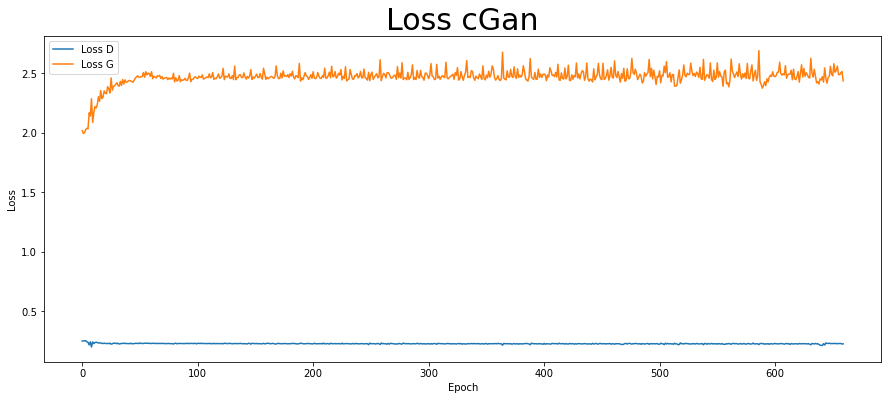

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(finald, label="Loss D")
plt.plot(finalg, label="Loss G")
plt.ylabel('Loss')
plt.xlabel('Epoch') 
plt.legend(loc="upper left")
plt.title("Loss cGan", fontsize=30) 
plt.show() 

### DATA LABELS

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

trainset['attack_cat'] = le.fit_transform(trainset['attack_cat'].values)
testset['attack_cat'] = le.transform(testset['attack_cat'].values)

mapping = dict(zip(le.classes_, le.transform(le.classes_)))
names = dict((v,k) for k,v in mapping.items())

In [ ]:
trainset.to_csv(r'train', index=False)
testset.to_csv(r'test', index=False)

### CREATION NEW DATA

In [ ]:
columnas = list(trainset.columns)
columnas.remove('attack_cat')

In [ ]:
num_rows_to_generate = 4956
label_to_generate = 9
noise = gen_noise(num_rows_to_generate, 32).to(device).float()
labels = torch.tensor([[label_to_generate] for _ in range(num_rows_to_generate)]).to(device)
fake_rows = G(noise, labels).tolist()
class9 = pd.DataFrame(fake_rows, columns=columnas)
class9['attack_cat'] = 9

In [ ]:
class9.to_csv(r'class9', index=False)

In [ ]:
num_rows_to_generate = 4622
label_to_generate = 8
noise = gen_noise(num_rows_to_generate, 32).to(device).float()
labels = torch.tensor([[label_to_generate] for _ in range(num_rows_to_generate)]).to(device)
fake_rows = G(noise, labels).tolist()
class8 = pd.DataFrame(fake_rows, columns=columnas)
class8['attack_cat'] = 8

In [ ]:
class8.to_csv(r'class8', index=False)

In [ ]:
num_rows_to_generate = 4417
label_to_generate = 1
noise = gen_noise(num_rows_to_generate, 32).to(device).float()
labels = torch.tensor([[label_to_generate] for _ in range(num_rows_to_generate)]).to(device)
fake_rows = G(noise, labels).tolist()
class1 = pd.DataFrame(fake_rows, columns=columnas)
class1['attack_cat'] = 1

In [ ]:
class1.to_csv(r'class1', index=False)

In [ ]:
num_rows_to_generate = 4323
label_to_generate = 0
noise = gen_noise(num_rows_to_generate, 32).to(device).float()
labels = torch.tensor([[label_to_generate] for _ in range(num_rows_to_generate)]).to(device)
fake_rows = G(noise, labels).tolist()
class0 = pd.DataFrame(fake_rows, columns=columnas)
class0['attack_cat'] = 0

In [ ]:
class0.to_csv(r'class0', index=False)

In [ ]:
num_rows_to_generate = 1504
label_to_generate = 7
noise = gen_noise(num_rows_to_generate, 32).to(device).float()
labels = torch.tensor([[label_to_generate] for _ in range(num_rows_to_generate)]).to(device)
fake_rows = G(noise, labels).tolist()
class7 = pd.DataFrame(fake_rows, columns=columnas)
class7['attack_cat'] = 7

### TRAINSET AUGMENTED

In [4]:
testset  = pd.read_csv('test.csv')
trainset  = pd.read_csv('train.csv')

class9  = pd.read_csv('class9.csv')
class8  = pd.read_csv('class8.csv')
class1  = pd.read_csv('class1.csv')
class0  = pd.read_csv('class0.csv')

In [5]:
trainset.shape

(82332, 21)

In [6]:
trainsetaug = pd.concat([trainset,class9,class8,class1,class0])

In [12]:
y_trainaug = trainsetaug["label"].apply(np.round).abs()
X_trainaug = trainsetaug.drop("label", 1)
trainsetaug.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


(100650, 21)

### SPLIT DATA

In [8]:
y_train = trainset["label"]
X_train = trainset.drop("label", 1)

y_test = testset["label"]
X_test = testset.drop("label", 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


# CLASSIFIERS 

### RANDOM FOREST: NO DATA AUGMENTATION

In [9]:
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators' : [5]}

model = GridSearchCV(estimator = RandomForestClassifier(), scoring='recall', param_grid = parameters)
model.fit(X_train, y_train)

means = model.cv_results_['mean_test_score']
stds = model.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, model.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.997 (+/-0.010) for {'n_estimators': 5}


In [49]:
from sklearn.metrics import classification_report

clf = RandomForestClassifier()
clf.fit(X_train, y_train)

y_predclf = clf.predict(X_test)

In [50]:
accuracy_score(y_test, y_predclf)
print(classification_report(y_test, y_predclf))

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92     56000
         1.0       1.00      0.92      0.96    119341

    accuracy                           0.95    175341
   macro avg       0.93      0.96      0.94    175341
weighted avg       0.96      0.95      0.95    175341



In [51]:
### RANDOM FOREST: DATA AUGMENTATION

In [52]:
clf = RandomForestClassifier()
clf.fit(X_trainaug, y_trainaug)

y_predclf = clf.predict(X_test)

In [53]:
accuracy_score(y_test, y_predclf)
print(classification_report(y_test, y_predclf))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56000
         1.0       1.00      0.96      0.98    119341

    accuracy                           0.97    175341
   macro avg       0.96      0.98      0.97    175341
weighted avg       0.97      0.97      0.97    175341



### CLASSICAL NEURAL NETWORK

In [37]:
class Net(nn.Module):
    def __init__(self,inp,H,output):
        super(Net,self).__init__()
        self.linear1=nn.Linear(inp,H)
        self.linear2=nn.Linear(H,output)
        
    def forward(self,x):
        x=torch.sigmoid(self.linear1(x))  
        x=self.linear2(x)
        return x
    # def __init_weights(self,m):
    #   if type(m) == nn.Linear:
    #     torch.nn.init.xavier_uniform_(m.weight)
    #     m.bias.data.fill_(0.01)
input_dim,hidden_dim,output_dim = 42, 10, 1
SimpleNN = Net(input_dim,hidden_dim,output_dim)

In [ ]:
batch_size = 32
learning_rate = 0.002 
num_epochs = 10
train_dataset = TensorDataset(X_train, y_train)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size,
                                              shuffle=True, num_workers=2)
test_dataset = TensorDataset(X_test, y_test)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,shuffle=True, num_workers=2)

In [ ]:
criterion = nn.MSE()
optimizer = torch.optim.Adam(SimpleNN.parameters(),lr=learning_rate)
for epoch in range(num_epochs): 
  epoch_loss = list() 
  for X_batch in train_dataset: 
    optimizer.zero_grad() 
    inputs, labels = X_batch
    inputs, labels = inputs.to(device), labels.to(device)
    
    output = SimpleNN(inputs) 
    loss = criterion(labels, output) 
 
    loss.backward() 
    optimizer.step() 
 
    epoch_loss.append(loss.item()) 
  print(f'[{epoch}/{num_epochs}]', f'loss: {np.array(epoch_loss).mean()}')

In [ ]:
with torch.no_grad():
  SimpleNN.eval()
  X_test, y_test = testloader
  y_pred = pred(SimpleNN(X_test)).to_numpy().detach()
  classification_report(np.around(y_pred),y_test)

### EXPLAINABLE BOOSTING MACHINE: NO DATA AUGMENTATION

In [55]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

y = ebm.predict(X_test)

In [59]:
accuracy_score(y_test, y)
print(classification_report(y_test, y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56000
         1.0       1.00      1.00      1.00    119341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341



In [28]:
### EXPLAINABLE BOOSTING MACHINE: DATA AUGMENTATION

In [58]:
ebm = ExplainableBoostingClassifier()
ebm.fit(X_trainaug, y_trainaug)

y = ebm.predict(X_test)

In [57]:
accuracy_score(y_test, y)
print(classification_report(y_test, y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56000
         1.0       1.00      1.00      1.00    119341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341

